In [17]:
import torch
import torch.nn.functional as F
from torch import nn
import whisper
from whisper.audio import (
    FRAMES_PER_SECOND,
    HOP_LENGTH,
    N_FRAMES,
    N_SAMPLES,
    SAMPLE_RATE,
    log_mel_spectrogram,
    pad_or_trim,
    load_audio,
)
import jiwer
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
model = whisper.load_model("base.en")

In [4]:
model

Whisper(
  (encoder): AudioEncoder(
    (conv1): Conv1d(80, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
    (blocks): ModuleList(
      (0-5): 6 x ResidualAttentionBlock(
        (attn): MultiHeadAttention(
          (query): Linear(in_features=512, out_features=512, bias=True)
          (key): Linear(in_features=512, out_features=512, bias=False)
          (value): Linear(in_features=512, out_features=512, bias=True)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (attn_ln): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (mlp_ln): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
    )
    (ln_post): LayerNorm((512,), eps=1e-05,

In [3]:
# collect trainable params
params = []
names = []
for nm, m in model.named_modules():
    # print(str(nm).split('.'))
    trainable = ['weight', 'bias']
    # train_LN
    if isinstance(m, nn.LayerNorm):
        for np, p in m.named_parameters():
            if np in trainable:  
                p.requires_grad = True
                params.append(p)
                names.append(f"{nm}.{np}")
    # train_feature
    if len(str(nm).split('.')) > 1:
        if str(nm).split('.')[0] == 'encoder' and (str(nm).split('.')[1] == 'conv1' or str(nm).split('.')[1] == 'conv2'):
            for np, p in m.named_parameters():
                p.requires_grad = True
                params.append(p)
                names.append(f"{nm}.{np}")
print(names)

['encoder.conv1.weight', 'encoder.conv1.bias', 'encoder.conv2.weight', 'encoder.conv2.bias', 'encoder.blocks.0.attn_ln.weight', 'encoder.blocks.0.attn_ln.bias', 'encoder.blocks.0.mlp_ln.weight', 'encoder.blocks.0.mlp_ln.bias', 'encoder.blocks.1.attn_ln.weight', 'encoder.blocks.1.attn_ln.bias', 'encoder.blocks.1.mlp_ln.weight', 'encoder.blocks.1.mlp_ln.bias', 'encoder.blocks.2.attn_ln.weight', 'encoder.blocks.2.attn_ln.bias', 'encoder.blocks.2.mlp_ln.weight', 'encoder.blocks.2.mlp_ln.bias', 'encoder.blocks.3.attn_ln.weight', 'encoder.blocks.3.attn_ln.bias', 'encoder.blocks.3.mlp_ln.weight', 'encoder.blocks.3.mlp_ln.bias', 'encoder.blocks.4.attn_ln.weight', 'encoder.blocks.4.attn_ln.bias', 'encoder.blocks.4.mlp_ln.weight', 'encoder.blocks.4.mlp_ln.bias', 'encoder.blocks.5.attn_ln.weight', 'encoder.blocks.5.attn_ln.bias', 'encoder.blocks.5.mlp_ln.weight', 'encoder.blocks.5.mlp_ln.bias', 'encoder.ln_post.weight', 'encoder.ln_post.bias', 'decoder.blocks.0.attn_ln.weight', 'decoder.blocks.0.

In [4]:
# load audio
model = model.to(DEVICE)
options = whisper.DecodingOptions(language="en", without_timestamps=True)
audio = load_audio(file='./p232_001.wav')
audio = pad_or_trim(audio)
mel = log_mel_spectrogram(audio)
mel = mel.unsqueeze(-1)
mel = mel.permute(2,0,1)

In [6]:
# forward
import whisper
mel = mel.to(DEVICE)
outputs = model.decode(mel, options)

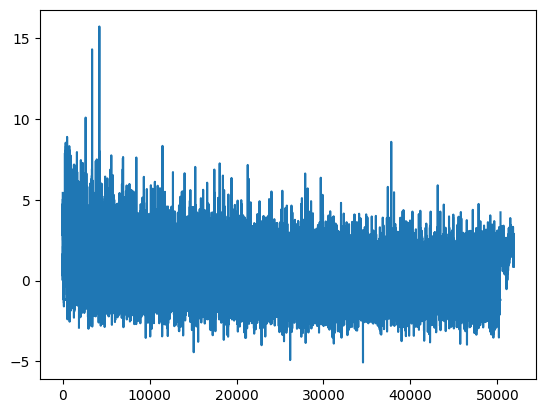

In [15]:
import matplotlib.pyplot as plt
plt.plot(outputs[1][0][0].cpu().numpy())

In [19]:
logprobs = F.log_softmax(outputs[1][0].float(), dim=-1)

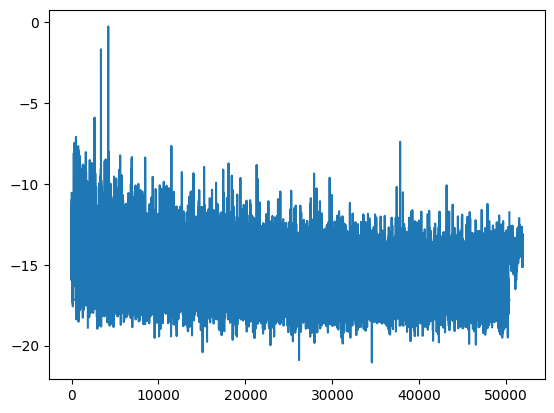

In [23]:
plt.plot(logprobs[0].cpu().numpy())

In [24]:
logprobs.argmax()

tensor(4222, device='cuda:0')

In [5]:
from whisper.decoding import DecodingTask

task = DecodingTask(model, options)


In [61]:
token = torch.Tensor(task.initial_tokens)
logit = model.decoder(token,model.encoder(mel))

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)

In [ ]:
predicted_ids = torch.argmax(outputs, dim=-1)
non_blank = torch.where(predicted_ids != 0, 1, 0).bool()

In [ ]:
# adapt
loss = 0
not_blank = True
if em_coef > 0: 
    if not_blank:      
        e_loss = softmax_entropy(outputs / temp)[non_blank].mean(0).mean()

    else: 
        e_loss = softmax_entropy(outputs / temp).mean(0).mean() 
    
    loss += e_loss * em_coef

if 1 - em_coef > 0: 
    c_loss = mcc_loss(outputs / temp, reweight)
    loss += c_loss * (1 - em_coef)

if div_coef > 0: 
    d_loss = div_loss(outputs, not_blank) 
    loss += d_loss * div_coef 

loss.backward()
optimizer.step()
if scheduler is not None: 
    scheduler.step()
model.zero_grad()

# inference again
if repeat_inference:
    with torch.no_grad():
        outputs = model(x).logits
return outputs

In [3]:
model = model.to(DEVICE)
options = whisper.DecodingOptions(language="en", without_timestamps=True)

In [7]:
model.encoder(mel).shape

torch.Size([1, 1500, 512])

In [17]:
results = model.decode(mel.to(DEVICE), options)

In [18]:
results

[DecodingResult(audio_features=tensor([[-4.9072e-01, -2.8223e-01, -1.9910e-01,  ...,  9.4727e-01,
          -5.4541e-01,  5.7324e-01],
         [ 6.1426e-01,  3.9844e-01,  5.8380e-02,  ...,  2.8638e-01,
          -1.3696e-01,  6.5967e-01],
         [ 6.5234e-01,  6.8164e-01,  7.3181e-02,  ...,  1.2720e-01,
          -4.4824e-01,  1.2455e-03],
         ...,
         [-5.0995e-02, -3.2135e-02, -3.2227e-02,  ..., -2.5711e-03,
           8.3847e-03, -1.8280e-02],
         [-1.7012e+00, -2.0837e-01,  4.0015e-01,  ...,  3.6743e-01,
          -1.3389e+00,  8.7012e-01],
         [-7.9834e-01, -2.4451e-01,  3.3179e-01,  ...,  4.9292e-01,
          -1.0127e+00,  2.0264e-01]], device='cuda:0', dtype=torch.float16), language='en', language_probs=None, tokens=[4222, 869, 45856, 13], text='Please call Stella.', avg_logprob=-0.3159170627593994, no_speech_prob=0.062296539545059204, temperature=0.0, compression_ratio=0.7037037037037037)]

In [21]:
for result in results:
    print(result.text)

Please call Stella.
